<a href="https://colab.research.google.com/github/mgswiss15/deepul/blob/2023/Homework_1_Autoregressive_Models_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone https://github.com/mgswiss15/deepul.git
    !git checkout 2023
    !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
    !pip install ./deepul
# else:
#     !pwd
#     !pip install ../../../deepul

Cloning into 'deepul'...
remote: Enumerating objects: 1516, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1516 (delta 19), reused 45 (delta 8), pack-reused 1447
Receiving objects: 100% (1516/1516), 130.11 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (846/846), done.
Updating files: 100% (129/129), done.
fatal: not a git repository (or any of the parent directories): .git
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=16663 sha256=21903fac5773457c595c9ecd58c90f400267ea8350078a4a8512d93e9990e6af
  Stored in directory: /tmp/pip-ephem-wheel-cache-a0ijejiv/wheels/ce/c2/d6/4d69bb00cfa0c828c46da8c4632fd88db08d755964dd153738
Successfully built deepul


In [3]:
from deepul.hw1_helper import *

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

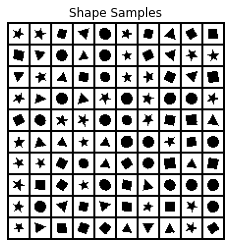

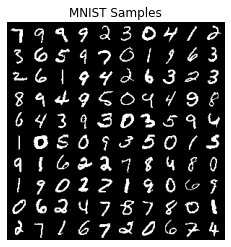

In [4]:
visualize_q2b_data(1)
visualize_q2b_data(2)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

### MG comment

Try with skip connections and following the prescribed archtiecture above.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedConv2d(nn.Conv2d):
  """2D conv layer with masking from PixelCNN (van den Oord, 2016).

  Autoregressive through masking previous pixels in conv operations.
  This is single channel only so does not do RGB autoregressive structure.

  Args:
    in_channels (int): Number of channels in the input image
    out_channels (int): Number of channels produced by the convolution
    kernel_size (int or tuple): Size of the convolving kernel

  """
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__(in_channels, out_channels, kernel_size)
    # masking matrix
    mask = torch.ones(out_channels, in_channels, kernel_size, kernel_size)
    cp = kernel_size // 2
    mask[:, :, cp+1:,:] = 0. # rows below
    mask[:, :, cp, cp:] = 0. # itself and everything to the right
    self.register_buffer('mask', mask)
    self.padding = 'same'

  def forward(self, x):
    return self._conv_forward(x, self.weight * self.mask, self.bias)

class PixelCnn(nn.Module):
  """PixelCNN reimplemented from van den Oord (2016).

  Ensures autoregressive masking through maksing kernels.
  This is single channel only so does not do RGB autoregressive structure.

  Args:
    channels (list): output channels in conv2d
    kernels (list): kernel sizes in conv2d
  """
  def __init__(self, channels, kernels):
    super().__init__()
    assert len(channels) == len(kernels), f'Lists channels and kernels are unequel length'
    self.depth = len(channels)

    # conv layers with relus
    self.layers = nn.ModuleList()
    self.skips = nn.ModuleList()
    in_channels = 1
    for i in range(self.depth):
      conv2d = MaskedConv2d(in_channels, channels[i], kernel_size=kernels[i])
      conv2d_relu = nn.Sequential(conv2d, nn.ReLU())
      self.layers.append(conv2d_relu)
      skip = nn.Sequential(MaskedConv2d(in_channels, channels[-1] // 2, kernel_size=kernels[i]), nn.ReLU())
      self.skips.append(skip)
      in_channels = channels[i]
    self.pre_final = nn.Sequential(nn.Conv2d(in_channels, in_channels // 2, kernel_size=1), nn.ReLU())
    self.final = nn.Conv2d(in_channels // 2, 1, kernel_size=1)

  def forward(self, x):
    # recode to [-1, 1]
    x = torch.where(x == 0., -1., 1.)
    skips = []
    for i in range(self.depth):
      # skips.append(self.skips[i](x))
      x = self.layers[i](x)
    x = self.pre_final(x)
    # skip connections
    # x = x + torch.sum(torch.stack(skips), dim=0)
    x = self.final(x)
    return x

### MG comment

Try residual connections as in pepar.

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
  """ResBlock as in PixelCNN (van den Oord, 2016))"""
  def __init__(self, channels):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(channels, channels // 2, 1),
        nn.ReLU(),
        MaskedConv2d(channels // 2, channels // 2, 3),
        nn.ReLU(),
        nn.Conv2d(channels // 2, channels, 1),
    )

  def forward(self, x):
    return x + self.layers(x)

class PixelCnn_Residual(nn.Module):
  """PixelCNN with residual blocks reimplemented from van den Oord (2016).

  Ensures autoregressive masking through maksing kernels.
  This is single channel only so does not do RGB autoregressive structure.

  Args:
    channels (int): output channels in conv2d
    kernel (int): kernel sizes in conv2d
    resblocks (int): number of resblocks
  """
  def __init__(self, channels, kernel, resblocks):
    super().__init__()

    # conv layers with relus
    self.first = MaskedConv2d(1, channels, kernel_size=kernel) 
    self.layers = nn.ModuleList()
    self.resblocks = resblocks
    for i in range(resblocks):
      self.layers.append(ResBlock(channels))
    self.pre_final = nn.Sequential(nn.ReLU(), nn.Conv2d(channels, channels // 2, kernel_size=1))
    self.final = nn.Sequential(nn.ReLU(), nn.Conv2d(channels // 2, 1, kernel_size=1))

  def forward(self, x):
    # recode to [-1, 1]
    x = torch.where(x == 0., -1., 1.)
    x = self.first(x)
    for i in range(self.resblocks):
      x = self.layers[i](x)
    x = self.pre_final(x)
    x = self.final(x)
    return x

In [28]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  import torch
  import torch.nn as nn
  import torch.optim as optim
  import torch.nn.functional as F
  import itertools
  from torch.utils.data import DataLoader, TensorDataset

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # move from numpy to torch and convert to NCHW
  train_data = torch.from_numpy(train_data).float().permute(0, 3, 1, 2)
  test_data = torch.from_numpy(test_data).float().permute(0, 3, 1, 2)
  # get num examples
  n_train = train_data.shape[0]

  # data loading
  b_size = 128
  train_ds = TensorDataset(train_data)
  test_ds = TensorDataset(test_data)
  train_loader = DataLoader(train_ds, batch_size = b_size, shuffle=True)
  test_loader = DataLoader(test_ds, batch_size = b_size, shuffle=False)

  # model
  # model = PixelCnn([16, 16, 64, 64, 64, 64], [7, 7, 7, 7, 7, 7]).to(device)
  model = PixelCnn_Residual(128, 7, 5).to(device)

  # loss
  def get_nll(input, target):
      return F.binary_cross_entropy_with_logits(input, target)

  # test loss - simple evaluatoin over test data
  def get_testnll():
      with torch.no_grad():
          for i, batch in enumerate(test_loader):
              nll = 0
              batch = batch[0].to(device)
              nll += get_nll(model(batch), batch).item()
          nll_test = nll / i
      return nll_test
  
  # optimizer
  lr = 0.001
  optimizer = optim.Adam(model.parameters(), lr=lr) 
  
  # training loop
  n_epochs = 10
  nll_train = []
  nll_test = [get_testnll()]
  for epoch in range(n_epochs):
      for batch in train_loader:
          optimizer.zero_grad(set_to_none=True)
          batch = batch[0].to(device)
          # apply model
          logits = model(batch)
          # get loss
          nll = get_nll(logits, batch)
          # sgd step
          nll.backward()
          optimizer.step()
          # monitor train nll
          nll_train.append(nll.item())
      # monitor test nll
      nll_test.append(get_testnll())
      if epoch % 1 == 0:
          print(f'Epoch {epoch}')
  
  # generate samples
  with torch.no_grad():
    b_size = 100
    samples = torch.randint(2, size = (b_size, 1, *(image_shape))).float().to(device)
    for j in range(image_shape[1]):
      for i in range(image_shape[0]):
        # get prob of respoective dimension
        logits = model(samples)
        probs = torch.sigmoid(logits)
        smpl = torch.bernoulli(probs[:, :, i, j])
        samples[:, :, i, j] = smpl

    # output for plotting needs to be NHWC
    samples = samples.permute(0, 2, 3, 1).to("cpu")
    samples = samples.numpy()

  return nll_train, nll_test, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



In [29]:
q3a_save_results(1, q3_a)

Epoch 0
Epoch 1


KeyboardInterrupt: ignored

Epoch 0
Epoch 5
Final Test Loss: 0.0019


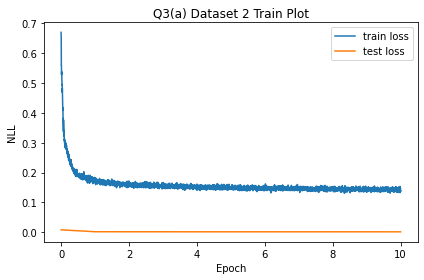

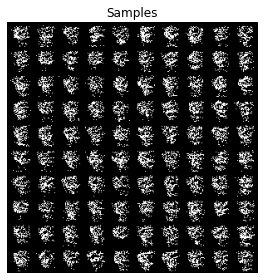

In [71]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

In [ ]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



In [ ]:
q3bc_save_results(1, 'b', q3_b)

In [ ]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



In [ ]:
q3bc_save_results(1, 'c', q3_c)

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



In [ ]:
q3d_save_results(1, q3_d)

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [ ]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [ ]:
q4c_save_results(q4_c)